<a href="https://colab.research.google.com/github/hithaankam/Alliance/blob/main/Stable_Diffusion_Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from huggingface_hub import model_info

model_name = "redstonehero/ReV_Animated_Inpainting"
try:
    info = model_info(model_name)
    print(f" Model '{model_name}' exists!")
except Exception as e:
    print(f" Model '{model_name}' not found. Error: {e}")


 Model 'redstonehero/ReV_Animated_Inpainting' exists!


In [ ]:
!rm -rf ~/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting


In [8]:
import torch

torch.cuda.empty_cache()
torch.cuda.ipc_collect()


Saving white_tshirt.jpg to white_tshirt (8).jpg


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


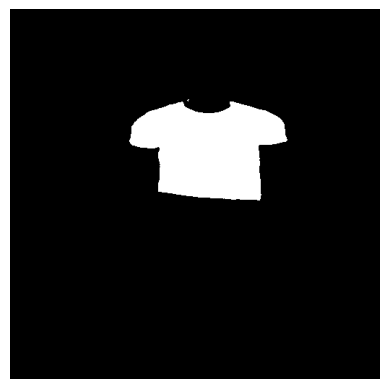

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.11/dist-packages/transformers/models/clip/f

  0%|          | 0/28 [00:00<?, ?it/s]

17023

In [9]:
import torch
import gc
import os
from torchvision import transforms
from transformers import SamModel, SamProcessor
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

#  Set environment variable to avoid memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

#  Clear GPU memory before execution
torch.cuda.empty_cache()
gc.collect()

#  Move heavy models to CPU if GPU is full
device = "cuda" if torch.cuda.is_available() and torch.cuda.memory_reserved() < 10 * 1024**3 else "cpu"

#  Load SAM model and processor (force CPU if GPU is full)
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-50").to(device).to(torch.float16 if device == "cuda" else torch.float32)
processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-50")

#  Upload and open an image
uploaded = files.upload()
img = Image.open(list(uploaded.keys())[0])

#  Resize image to reduce memory usage
img = img.resize((512, 512))  # Adjust as needed

#  Define input points
input_points = [[[256, 256]]]  # Adjust coordinates based on new image size
inputs = processor(img, input_points=input_points, return_tensors="pt").to(device).to(torch.float16 if device == "cuda" else torch.float32)

#  Run the model (Move back to CPU if GPU is full)
with torch.no_grad():  # Disables gradient calculation to save memory
    if device == "cuda":
        try:
            outputs = model(**inputs)
        except torch.cuda.OutOfMemoryError:
            print("🚨 GPU ran out of memory! Moving model to CPU...")
            model.to("cpu")
            device = "cpu"
            inputs = inputs.to("cpu")
            outputs = model(**inputs)
    else:
        outputs = model(**inputs)

#  Extract mask tensors
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)

#  Display mask
plt.imshow(masks[0][0][2], cmap="gray")
plt.axis("off")
plt.show()

#  Convert mask to PIL image
to_pil = transforms.ToPILImage()
mask_1 = to_pil(masks[0][0][2].to(dtype=torch.uint8) * 255)
mask_1.show()

#  Unload SAM model from GPU (if needed)
del model
gc.collect()
torch.cuda.empty_cache()

#  Load inpainting pipeline with memory optimization
pipeline = AutoPipelineForInpainting.from_pretrained(
    "redstonehero/ReV_Animated_Inpainting",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)
pipeline.enable_model_cpu_offload()  # Moves unused layers to CPU to save VRAM

#  Inpainting example
prompt = "flower-print, t-shirt"
image1 = pipeline(
    prompt=prompt,
    width=512,
    height=512,
    num_inference_steps=28,
    image=img,
    mask_image=mask_1,
    guidance_scale=3,
    strength=1.0
).images[0]

#  Display original and inpainted images
make_image_grid([img, image1], cols=2, rows=1)

#  Free GPU memory after execution
torch.cuda.empty_cache()
gc.collect()


In [13]:
!huggingface-cli download redstonehero/ReV_Animated_Inpainting --resume-download



/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 17 files:   0% 0/17 [00:00<?, ?it/s]Downloading 'README.md' to '/root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/blobs/431f5b7831b3f0cc7be5b0ab76984be338a2cca3.incomplete'

README.md: 100% 90.0/90.0 [00:00<00:00, 466kB/s]
Download complete. Moving file to /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/blobs/431f5b7831b3f0cc7be5b0ab76984be338a2cca3

.gitattributes: 100% 1.48k/1.48k [00:00<00:00, 10.1MB/s]
Download complete. Moving file to /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/blobs/c7d9f3332a950355d5a77d85000f05e6f45435ea
Fetching 17 files: 100% 17/17 [00:00<00:00, 49.97it/s]
/root/.cache/huggingface/hub/models

In [3]:
!huggingface-cli download redstonehero/ReV_Animated_Inpainting --resume-download --local-dir ~/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 17 files: 100% 17/17 [00:36<00:00,  2.17s/it]
/root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting


Saving white_tshirt.jpg to white_tshirt (9).jpg


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


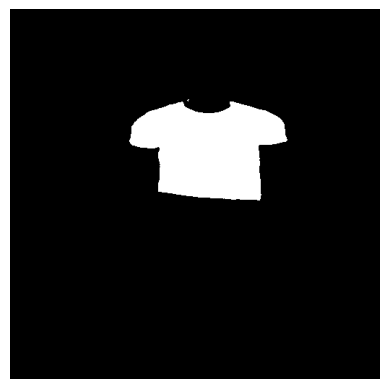

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.11/dist-packages/transformers/models/clip/f

  0%|          | 0/28 [00:00<?, ?it/s]

17023

In [10]:
import torch
import gc
import os
from torchvision import transforms
from transformers import SamModel, SamProcessor
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

#  Set environment variable to avoid memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

#  Clear GPU memory before execution
torch.cuda.empty_cache()
gc.collect()

#  Move heavy models to CPU if GPU is full
device = "cuda" if torch.cuda.is_available() and torch.cuda.memory_reserved() < 10 * 1024**3 else "cpu"

#  Load SAM model and processor (force CPU if GPU is full)
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-50").to(device).to(torch.float16 if device == "cuda" else torch.float32)
processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-50")

#  Upload and open an image
uploaded = files.upload()
img = Image.open(list(uploaded.keys())[0])

#  Resize image to reduce memory usage
img = img.resize((512, 512))  # Adjust as needed

#  Define input points
input_points = [[[256, 256]]]  # Adjust coordinates based on new image size
inputs = processor(img, input_points=input_points, return_tensors="pt").to(device).to(torch.float16 if device == "cuda" else torch.float32)

#  Run the model (Move back to CPU if GPU is full)
with torch.no_grad():  # Disables gradient calculation to save memory
    if device == "cuda":
        try:
            outputs = model(**inputs)
        except torch.cuda.OutOfMemoryError:
            print("🚨 GPU ran out of memory! Moving model to CPU...")
            model.to("cpu")
            device = "cpu"
            inputs = inputs.to("cpu")
            outputs = model(**inputs)
    else:
        outputs = model(**inputs)

#  Extract mask tensors
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)

#  Display mask
plt.imshow(masks[0][0][2], cmap="gray")
plt.axis("off")
plt.show()

#  Convert mask to PIL image
to_pil = transforms.ToPILImage()
mask_1 = to_pil(masks[0][0][2].to(dtype=torch.uint8) * 255)
mask_1.show()

#  Unload SAM model from GPU (if needed)
del model
gc.collect()
torch.cuda.empty_cache()

#  Load inpainting pipeline with memory optimization
pipeline = AutoPipelineForInpainting.from_pretrained(
    "redstonehero/ReV_Animated_Inpainting",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)
pipeline.enable_model_cpu_offload()  # Moves unused layers to CPU to save VRAM

#  Inpainting example
prompt = "flower-print, t-shirt"
image1 = pipeline(
    prompt=prompt,
    width=512,
    height=512,
    num_inference_steps=28,
    image=img,
    mask_image=mask_1,
    guidance_scale=3,
    strength=1.0
).images[0]

#  Display original and inpainted images
make_image_grid([img, image1], cols=2, rows=1)

#  Free GPU memory after execution
torch.cuda.empty_cache()
gc.collect()


Saving white_tshirt.jpg to white_tshirt (10).jpg


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


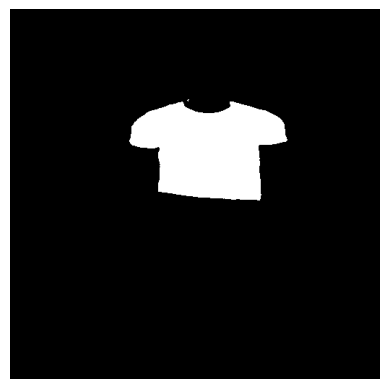

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.11/dist-packages/transformers/models/clip/f

  0%|          | 0/28 [00:00<?, ?it/s]

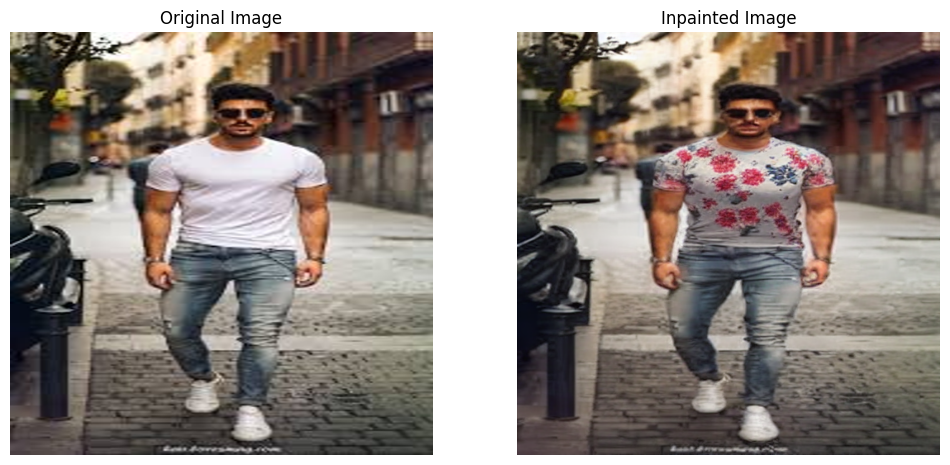

21390

In [11]:
import torch
import gc
import os
from torchvision import transforms
from transformers import SamModel, SamProcessor
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

#  Set environment variable to avoid memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

#  Clear GPU memory before execution
torch.cuda.empty_cache()
gc.collect()

#  Check GPU memory availability and move to CPU if needed
device = "cuda" if torch.cuda.is_available() and torch.cuda.memory_reserved() < 10 * 1024**3 else "cpu"

#  Load SAM model and processor (force CPU if GPU is full)
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-50").to(device).to(torch.float16 if device == "cuda" else torch.float32)
processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-50")

#  Upload and open an image
uploaded = files.upload()
img = Image.open(list(uploaded.keys())[0])

#  Resize image to reduce memory usage
img = img.resize((512, 512))  # Adjust as needed

#  Define input points
input_points = [[[256, 256]]]  # Adjust coordinates based on new image size
inputs = processor(img, input_points=input_points, return_tensors="pt").to(device).to(torch.float16 if device == "cuda" else torch.float32)

#  Run the model (Move back to CPU if GPU is full)
with torch.no_grad():  # Disables gradient calculation to save memory
    if device == "cuda":
        try:
            outputs = model(**inputs)
        except torch.cuda.OutOfMemoryError:
            print("🚨 GPU ran out of memory! Moving model to CPU...")
            model.to("cpu")
            device = "cpu"
            inputs = inputs.to("cpu")
            outputs = model(**inputs)
    else:
        outputs = model(**inputs)

#  Extract mask tensors
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)

#  Display mask
plt.imshow(masks[0][0][2], cmap="gray")
plt.axis("off")
plt.show()

#  Convert mask to PIL image
to_pil = transforms.ToPILImage()
mask_1 = to_pil(masks[0][0][2].to(dtype=torch.uint8) * 255)
mask_1.show()

#  Unload SAM model from GPU (if needed)
del model
gc.collect()
torch.cuda.empty_cache()

#  Load inpainting pipeline with memory optimization
pipeline = AutoPipelineForInpainting.from_pretrained(
    "redstonehero/ReV_Animated_Inpainting",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)
pipeline.enable_model_cpu_offload()  # Moves unused layers to CPU to save VRAM

#  Inpainting example with a prompt
prompt = "flower-print, t-shirt"
image1 = pipeline(
    prompt=prompt,
    width=512,
    height=512,
    num_inference_steps=28,
    image=img,
    mask_image=mask_1,
    guidance_scale=3,
    strength=1.0
).images[0]

#  Display original and inpainted images side by side
plt.figure(figsize=(12, 6))

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# Show inpainted image
plt.subplot(1, 2, 2)
plt.imshow(image1)
plt.title("Inpainted Image")
plt.axis('off')

plt.show()

#  Free GPU memory after execution
torch.cuda.empty_cache()
gc.collect()
